In [11]:
import csv, os, sys
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import geopandas as gpd
import pydeck as pdk

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator, LogLocator, ScalarFormatter,FormatStrFormatter
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import pylab as pl
import seaborn as sns
import colorcet as cc
import string
import warnings

import pydeck as pdk
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os
import time


In [ ]:
#
# PlotPopByGridGivenUAGivenPolygon.py
#
ver = 'v46'
pap_ver = '250228'
pred_type = 'pessimistic'
pred_type = 'intermediate'

radius = 2000

#years = [1970,2020,2070,2120]
base_year = 2020
year =2120
ua = 5
min_pop = 100
buffer_size = .1

buffer_y = 0.1 # move the center of the map in the latitude direction
size_x = 1000
size_y = 1400



background = 'none'

if background == 'web':
    bgcolor = '#fffcf9'
else:
    bgcolor = '#ffffff'
    
ua_colors = {1:[139,0,0],\
             2:[255,0,0],\
             3:[255,69,0],\
             4:[255,140,0],\
             5:[255,215,0],\
             6:[255,250,205]}              
ru_colors = {1:[211,211,211],\
             2:[220,220,220],\
             3:[245,245,245]}

# basedir = '../Discussions/' +ver + '/' + pred_type + '/'
# uadir = '../../UA/jp/map/'
# mapdir =  basedir + 'map/'
# outdir = '../versions/' + pap_ver + '/Figs/'

basedir = os.path.join(ver, pred_type)
uadir = 'Map'
mapdir =  basedir
outdir = 'output'

# polygon = '../versions/' + pap_ver + '/shapes/tenjin_circle_' + str(radius) + 'm.shp'
# polygon = os.path.join()

name_file = os.path.join(basedir, 'ua_names_2020_M.csv')
pop_file = os.path.join(basedir, 'mesh3_pop_1970-2200.csv')

mesh_file = os.path.join(uadir, 'mesh3', 'mesh3_on_contiguous_EPSG4326_WGS84.geojson')
ua_file = os.path.join(mapdir, 'ua_1000_minpop_10000_1970-2200.shp')
coast_file = os.path.join(uadir, 'coast_EPSG4326_WGS84.geojson')

cell_file = os.path.join(basedir, 'ua_cells_prediction_1970-2200.csv')
# outfig = outdir + 'fig_cities_' + pred_type + '_min-pop_' +\
# str(min_pop)+ '_wo_map_' +  str(year) + '.html'
outfig = os.path.join(outdir, f'fig_tenjin-density_radius-{radius}m_in_ua_{ua}_base-year_{base_year}_{ver}_{pred_type}_bgcolor_{background}_{year}.html')

outpng = os.path.join(outdir, f'fig_tenjin-density_{pred_type}_min-pop_{min_pop}_wo_map_{year}.png')

marker_size = 10
title_size = 25
label_size = 25
ann_size = 25
tick_size = 25
pad_size = 10

x_pad_size = 5
x_log_padsize = -5
y_pad_size = 10
y_log_padsize = 10

pad_title = 1.05
labelspacing=0.2
wspace=0.2
hspace=0.

In [34]:
warnings.simplefilter('ignore')
print(basedir)
print('Background color', background)
print('UA',ua,', Year',year, 'Base year for polygon',base_year)

print('Reading grid-level population ...')
dfpop = pd.read_csv(pop_file,header=0,index_col=False)
dfpop = dfpop[dfpop.YEAR==year]
dfpop = dfpop[['CELL_ID','POP','YEAR']]

print('Reading gird map ...')
dfmesh = gpd.read_file(mesh_file)
dfmesh = dfmesh.astype({'CELL_ID':'int64'})
dfmesh = dfmesh[['CELL_ID','geometry']]
dfmesh['LON'] = dfmesh['geometry'].centroid.x
dfmesh['LAT'] = dfmesh['geometry'].centroid.y
df = dfmesh.merge(dfpop,on='CELL_ID')
df = df[['CELL_ID','POP','LON','LAT','YEAR','geometry']]

print('Reading UA ...')
dfua = gpd.read_file(ua_file)
#dfua = dfua[(dfua.YEAR==year)&(dfua.UA==ua)]
dfua = dfua[(dfua.YEAR==base_year)&(dfua.UA==ua)]
dfua = dfua.to_crs(dfmesh.crs)

dfuab = dfua.buffer(distance=buffer_size)


dfuab = gpd.GeoDataFrame(dfuab)
dfuab.rename(columns={0:'geometry'},inplace=True)
dfuab.set_geometry('geometry',inplace=True)
dfuab = gpd.GeoDataFrame(dfuab,crs=dfua.crs)


coast = gpd.read_file(coast_file)
dfc = gpd.overlay(coast,dfuab,how='intersection')
dfmu =gpd.overlay(df,dfc,how='intersection')

geo_center = (dfua.unary_union.centroid.x,\
              dfua.unary_union.centroid.y - buffer_y)

view_state = pdk.ViewState(
    **{"latitude": geo_center[1], "longitude":geo_center[0],\
       "zoom": 10, "maxZoom": 16, "pitch": 40, "bearing": -17})


# geo_center = (coast.unary_union.centroid.x,\
#               coast.unary_union.centroid.y)

# view_state = pdk.ViewState(
#     **{"latitude": 37.0, "longitude":136.038,\
#        "zoom": 6, "maxZoom": 16, "pitch": 40, "bearing": -17})


print('Reading UA cells ...')
dfcell = pd.read_csv(cell_file)
dfcell = dfcell[dfcell.YEAR==year]
dfcell = dfcell[['CELL_ID','UA','YEAR']]

df = dfmu.merge(dfcell[dfcell.UA==ua],on=['CELL_ID','YEAR'],how='left')
df = df[['CELL_ID','YEAR','UA','POP','LON','LAT','geometry']]
df['UA'] = df['UA'].fillna(0)

df = df.astype({'UA':'int64'})
df = df[df.POP>min_pop]
df.reset_index(inplace=True)
df.drop('index',axis='columns',inplace=True)

# df_polygon = gpd.read_file(polygon)
# df_polygon = df_polygon.to_crs(df.crs)

#df['centroid'] = df.geometry.apply(lambda x: x.centroid)
df_centroids = gpd.GeoDataFrame(
    geometry=df.geometry.apply(lambda x: x.centroid),
    crs=df.crs
)
df_centroids = df.iloc[df_centroids.index]

# filtered_centroids = gpd.sjoin(
#     df_centroids, 
#     df_polygon, 
#     how='inner'
# )
filtered_centroids = df_centroids.copy()

#df['centroid'] = df.geometry.apply(lambda x: x.centroid)

# df_filtered = df[
#     filtered_centroids.apply(lambda x: df_polygon.geometry.iloc[0].contains(x))
# ]


# # メッシュの重心をGeoDataFrameとして作成
# df_centroids = gpd.GeoDataFrame(
#     geometry=df.geometry.apply(lambda x: x.centroid),
#     crs=df.crs
# )

# 重心が円内にあるものを特定
# filtered_centroids = gpd.sjoin(
#     df_centroids, 
#     df_polygon, 
#     how='inner', 
#     op='intersects'
# )


v46/intermediate
Background color none
UA 5 , Year 2120 Base year for polygon 2020
Reading grid-level population ...
Reading gird map ...
Reading UA ...
Reading UA cells ...


<Axes: >

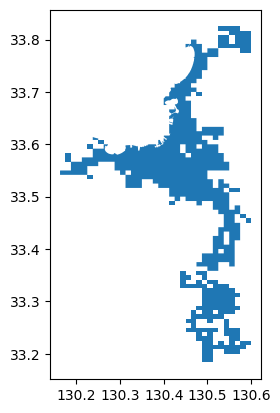

In [38]:
dfua.plot()

In [35]:

color_column = []
for i in df.index:

    if df.iloc[i]['UA'] > 0:
        val = df.iloc[i]['POP']

        if df.iloc[i]['CELL_ID'] in set(filtered_centroids['CELL_ID']):
                
            if val > 20000:
                color_column.append(ua_colors[1])
            elif val > 15000:
                color_column.append(ua_colors[2])
            elif val > 10000:
                color_column.append(ua_colors[3])
            elif val > 5000:
                color_column.append(ua_colors[4])
            elif val > 2000:
                color_column.append(ua_colors[5])
            else:
                color_column.append(ua_colors[6])
        else:
            color_column.append(ru_colors[1])            
    else:
        color_column.append(ru_colors[3])




In [36]:
df['FILL_COLOR'] = color_column
#dfc['FILL_COLOR']= [[245,222,179]]
dfc['FILL_COLOR']= bgcolor

dfc['EDGE_COLOR'] = [[0,0,0]]
dfc['ELV'] = 0

polygon = pdk.Layer(
    "GeoJsonLayer",
    data=dfc,
    opacity=0.2,    
    filled=False,
    stroked=True,
    extruded=True,
    wireframe=True,    
    # processes the data as a flat longitude-latitude pair
#    get_polygon="-",
    # elevationScale=5,
    # lineWidthUnits='pixels',
    # lineWidthMinPixels=10,
    get_elevation="0",
    get_fill_color="none",
    get_line_color="EDGE_COLOR")

geojson = pdk.Layer(
    "ColumnLayer",
    data=df,
    auto_highlight=False,
    elevation_scale=1,
    pickable=True,
#    get_radius=,
    coverage=0.5,
    opacity=0.15,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    get_position=['LON','LAT'],
    get_elevation="POP",
    get_fill_color="FILL_COLOR",
    get_line_color="FILL_COLOR"
)

# r = pdk.Deck(layers=[polygon,geojson],map_provider="mapbox",\
#              api_keys={'mapbox':'pk.eyJ1IjoidG9tb3lhLW1vcmkiLCJhIjoiY2xwN21rczJuMXozNjJrcXY5enRxOWZyeCJ9.7vI4I8etICPpEnbFrZ8pHA'},\
#              map_style='mapbox://styles/tomoya-mori/clp7n37kd00g601r6fpji0cod',initial_view_state=view_state)
r = pdk.Deck(layers=[polygon,geojson],initial_view_state=view_state,map_provider='none')

r.to_html(outfig,css_background_color=(bgcolor))


In [37]:
# Chrome headlessモード設定
options = Options()
options.add_argument("--headless")
options.add_argument(f"--window-size={size_x},{size_y}")

# Chrome Driver起動
driver = webdriver.Chrome(options=options)
driver.get("file://" + os.path.abspath(outfig))

# レンダリング待ち（時間調整可能）
time.sleep(5)

# スクリーンショット保存
driver.save_screenshot(outpng)
driver.quit()

print("Saved figure to", outpng)

Saved figure to output/fig_tenjin-density_intermediate_min-pop_100_wo_map_2120.png
